# <center>Atividade Final</center>

1. Resultados (curvas e Matrizes de confusão) da CNN com Bootstrap

2. Resultados da CNN com Fine tuning  

3. Resultados (curvas e Matrizes de confusão) da CNN com Bootstrap com algum pré-processing.

4. Resultados da CNN com Fine tuning  com algum pré-processing.

5. Relatórios indicando o resultado com  e sem pré-processamento (porém com data augmentation)  usando as mesmas configurações da  da rede.

Deve haver aumento na  acurácia, ou a prova que mesmo aplicando todos os algoritmos não ouve mudança.

Algoritmos

1. Operadores Morfológicos.

2. Segmentação

3. Suavização, Realce, Detecção de Bordas

4. Transformação para Domínio da frequência (não obrigatório).

5. Cornerfeature (não obrigatório)

## Para acessar os arquivos

Acessar o link da pasta do Drive compartilhada. Em 'Compartilhado Comigo', gerenciar a pasta VC-PROJETO FINAL, e adicionar atalho para a pasta raiz do drive.

'https://drive.google.com/drive/folders/1hVWiNDidqRSIGvP689XP2H4PXi9LH-Xj?usp=sharing'

Apresentação:

https://docs.google.com/presentation/d/1k8s2V1b4DRUaCh8J5aaJf4bP786AaXC1MHj8ORQXEMY/edit?usp=sharing

## Imports

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from collections import defaultdict
from pathlib import Path, PurePath
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import zipfile


import keras
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, BackupAndRestore
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def gridplot(img_list: list,
             cols: int,
             ):
    fig, ax = plt.subplots(nrows=int(-(-len(img_list)//cols)),
                           ncols=cols,
                           figsize=(7*cols, 5*int(-(-len(img_list)//cols))),
                           squeeze=False
                           )
    for i, x in enumerate(img_list):
        ax[i//cols, i%cols].imshow(x)

## Dataset

Coletando os dados.

### Batch size

In [ ]:
download_dir = Path('/content/drive/MyDrive/VC-PROJETO_FINAL')
ds = './Dataset'
BATCH_SIZE = 64

Para os modelos 1 e 2: Dataset.zip

Para os modelos 3 e 4: Dataset_open.zip

Para os modelos 5 e 6: Dataset_PP.zip

Para os modelos 7 e 8: Dataset_PR.zip

In [ ]:
with zipfile.ZipFile(str(download_dir)+'/Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(ds)

In [ ]:
class_subset = sorted(os.listdir(ds+'/test'))
class_subset

['anabele', 'chris', 'diniz', 'manuela', 'matheus', 'michel', 'pablo']

## Criação do modelo

In [ ]:
def create_model(input_shape: tuple,
                 n_classes: int,
                 optimizer: str='rmsprop',
                 fine_tune: int=0,
                 ):
    """
    Compiles a model integrated with Densenet pre-trained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pre-trained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = DenseNet121(include_top=False,
                            weights='imagenet',
                            input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pre-trained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

testing = test_generator.flow_from_directory(ds+'/test',
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

input_shape = testing[0][0].shape
optim_1 = Adam(learning_rate=0.001)
n_classes=len(class_subset)


Found 166 images belonging to 7 classes.


Dentro da pasta models estão os modelos treinados:

1 - Sem pré-processamento e sem fine tuning

2 - Sem pré-processamento e com fine tuning

3 - Com pré-processamento e sem fine tuning
- Abertura

4 - Com pré-processamento e com fine tuning
- Abertura

5 - Sem pré-processamento e com fine tuning
- Detecção de borda e equalização de histograma

6 - Com pré-processamento e com fine tuning
- Detecção de borda e equalização de histograma

7 - Sem pré-processamento e com fine tuning
- Detecção de borda e equalização de histograma com suavização

8 - Com pré-processamento e com fine tuning
- Detecção de borda e equalização de histograma com suavização

In [ ]:
path = str(download_dir)+'/models/tattoo_1'


# Generate predictions

### NO FINE TUNE ###
#dense_imodel = create_model(input_shape, n_classes, optim_1, fine_tune=0)

### FINE TUNE ###
dense_imodel = create_model(input_shape, n_classes, optim_1, fine_tune=9)


#dense_imodel = load_model(filepath=path+'/tattoo_weights.hdf5')
dense_imodel.load_weights(filepath=path+'/tattoo_weights.hdf5') # initialize the best trained weights

true_classes = testing.classes

class_indices = testing.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
dense_pred_classes = np.argmax(dense_imodel.predict(testing), axis=-1)
dense_acc = accuracy_score(true_classes, dense_pred_classes)
print("DenseNet Model Accuracy without Fine-Tuning: {:.2f}%".format(dense_acc * 100))

166/166 [==============================] - 5s 20ms/step
DenseNet Model Accuracy without Fine-Tuning: 69.28%


### Apresentação das estatísticas do treinamento

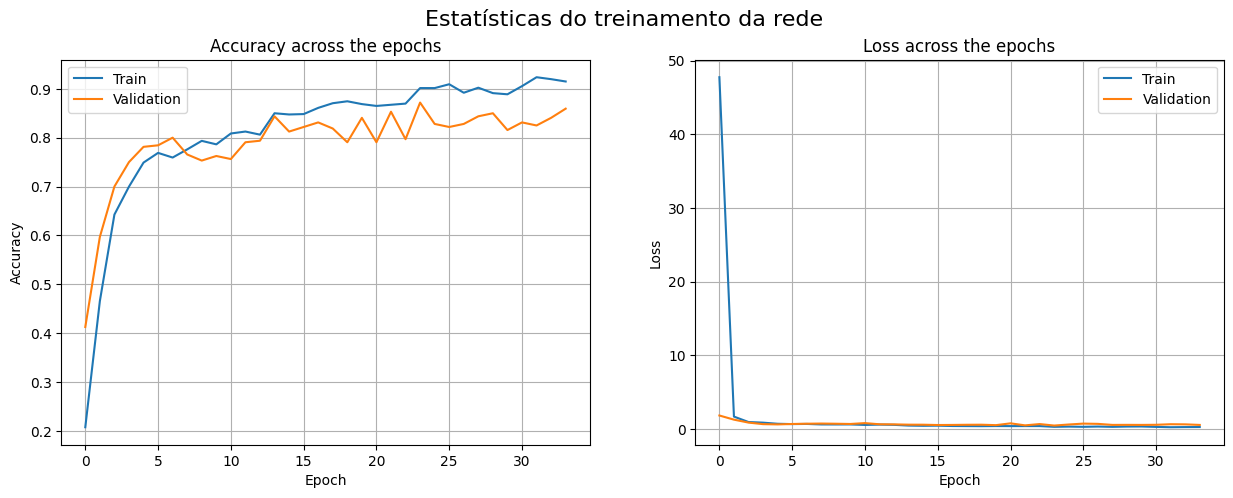

In [ ]:
dense_history = pd.read_csv(path+'/treinamento.csv')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(dense_history['accuracy'])
ax[0].plot(dense_history['val_accuracy'])
ax[0].grid(True)
ax[0].legend(['Train' , 'Validation'])
ax[0].set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy across the epochs')
#plt.gca().set_ylim(0,3)

ax[1].plot(dense_history['loss'])
ax[1].plot(dense_history['val_loss'])
ax[1].grid(True)
ax[1].legend(['Train' , 'Validation'])
ax[1].set(xlabel='Epoch', ylabel='Loss', title='Loss across the epochs')

plt.suptitle('Estatísticas do treinamento da rede', fontsize=16)
plt.show()

In [ ]:
def display_results(y_true, y_preds, class_labels):

    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)

    results.sort_values(by='F-Score', ascending=False, inplace=True)
    global_acc = accuracy_score(y_true, y_preds)

    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices, size):

    fig = plt.figure(figsize=(20, size))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=size, replace=False)):
        ax = fig.add_subplot(int(size/5), 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]),)
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]

        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

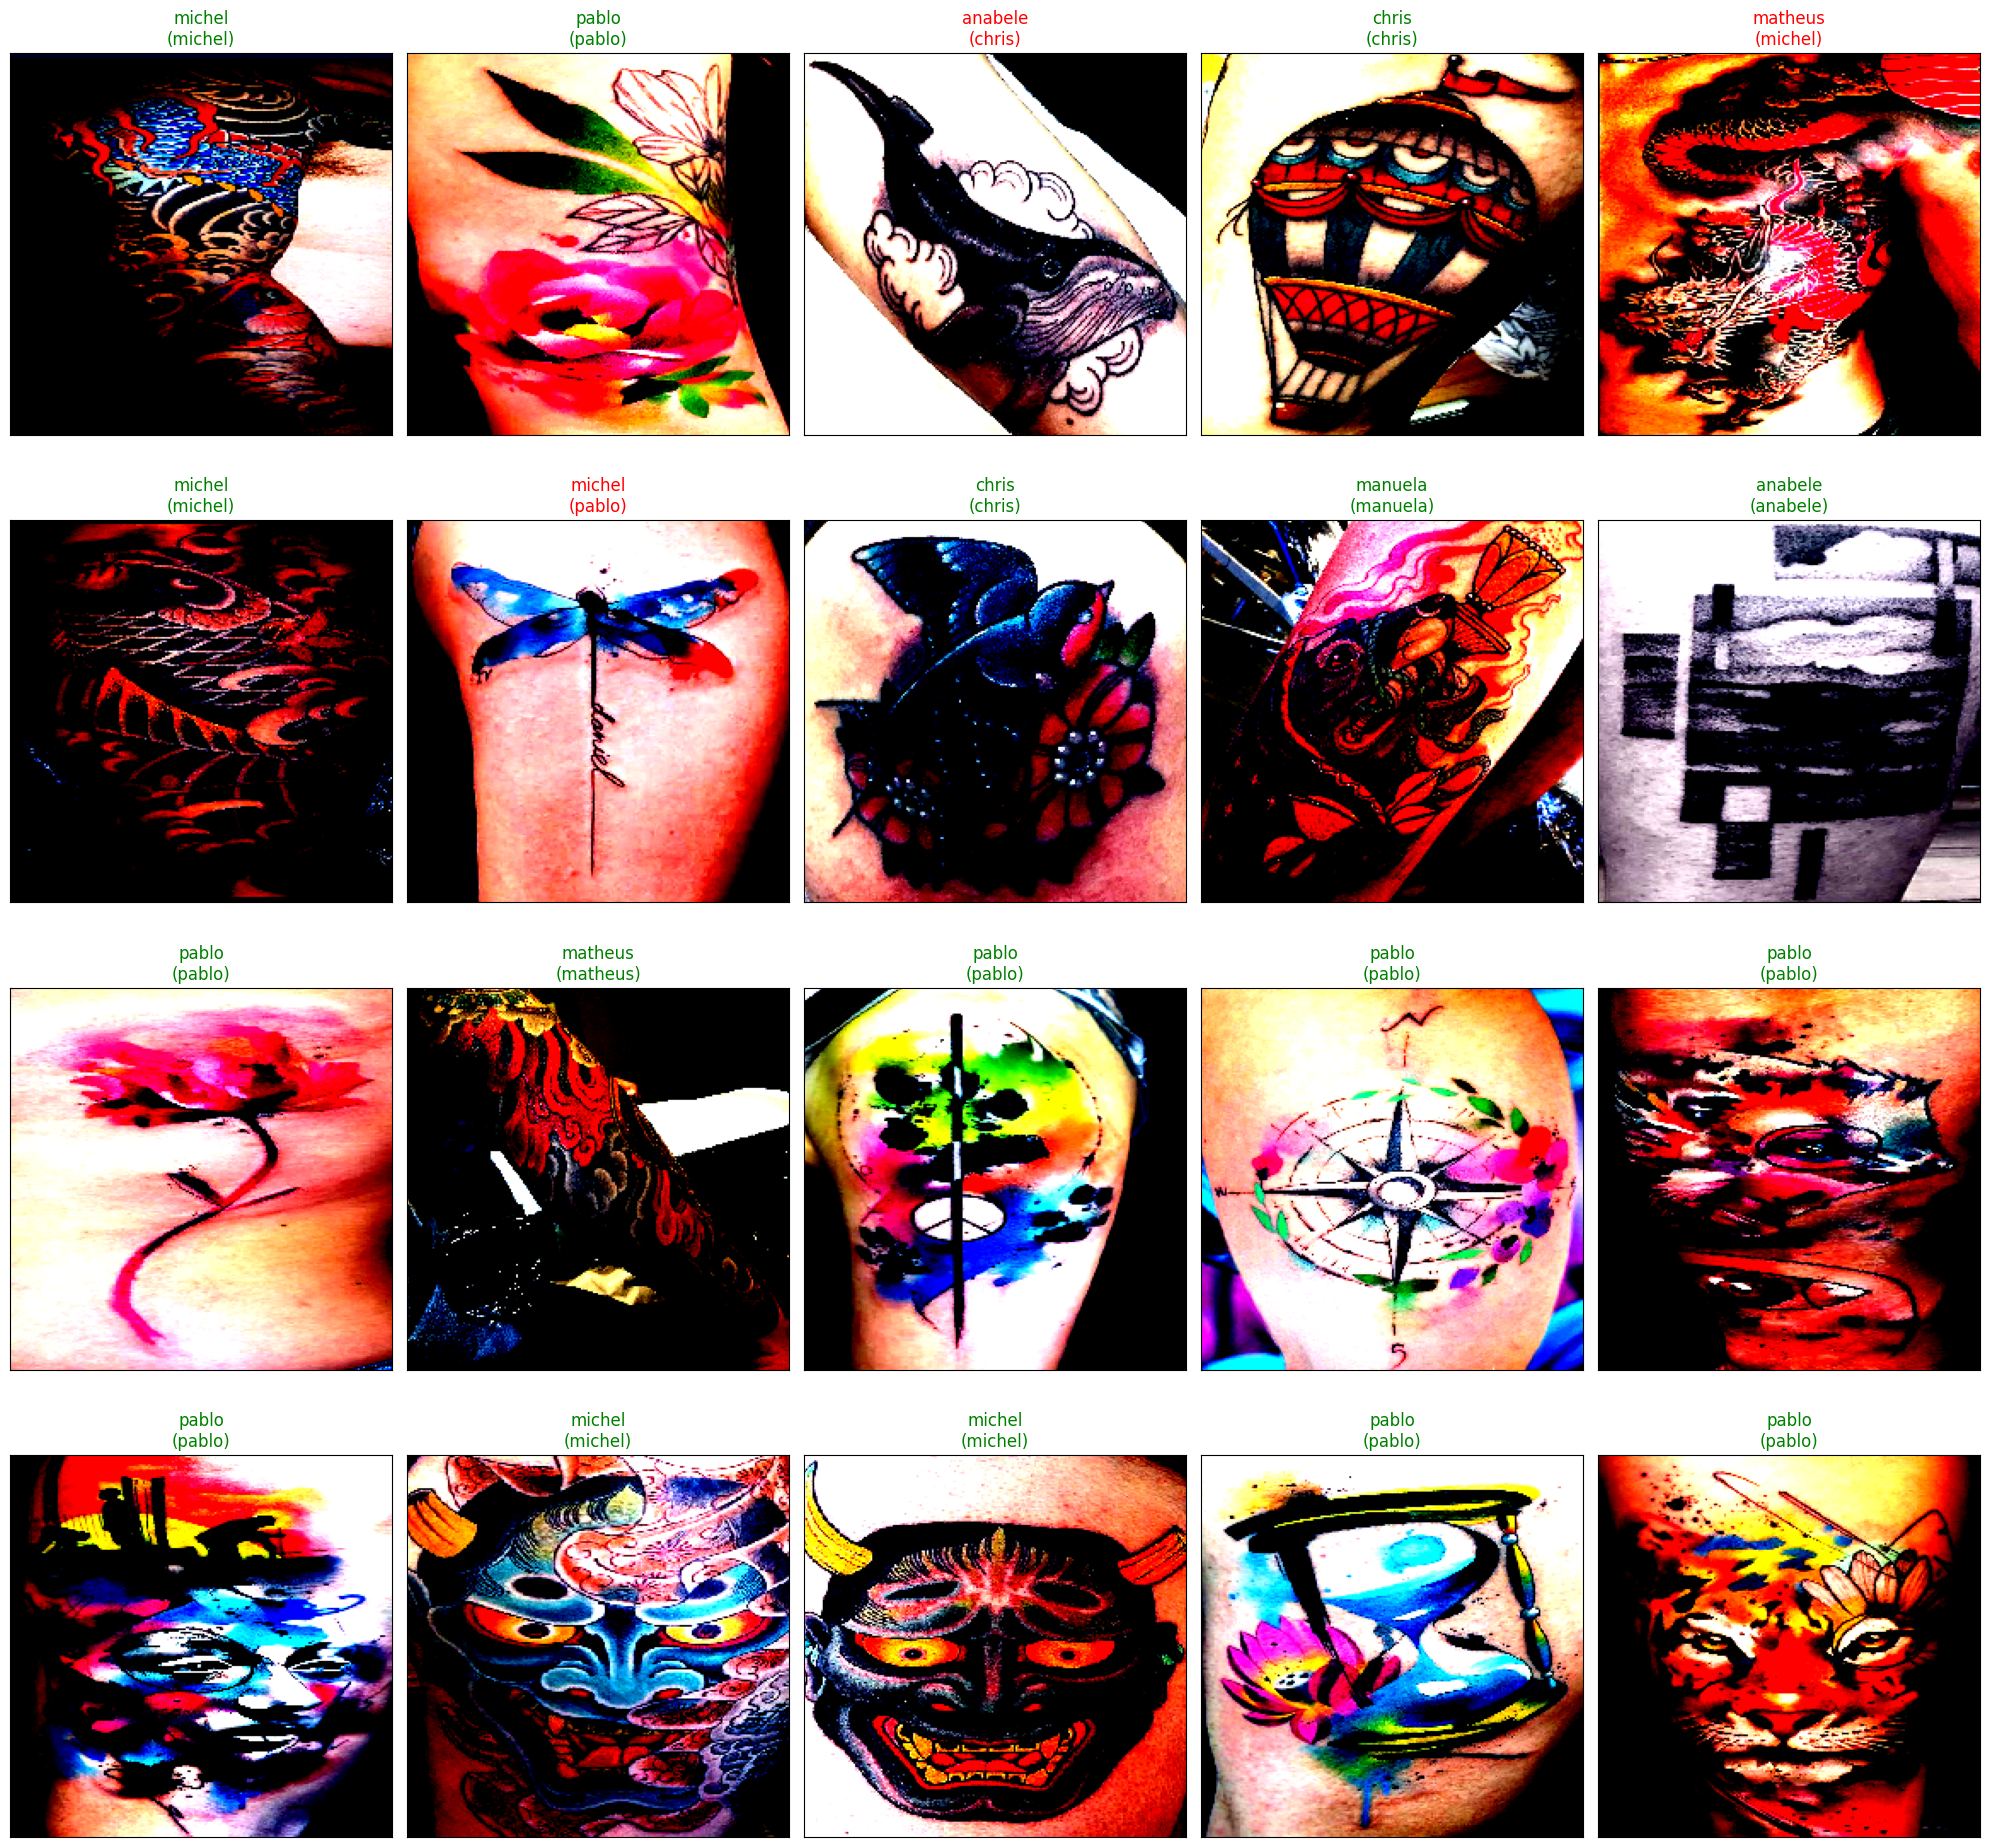

In [ ]:
plot_predictions(true_classes, dense_pred_classes, testing, class_indices, 20)

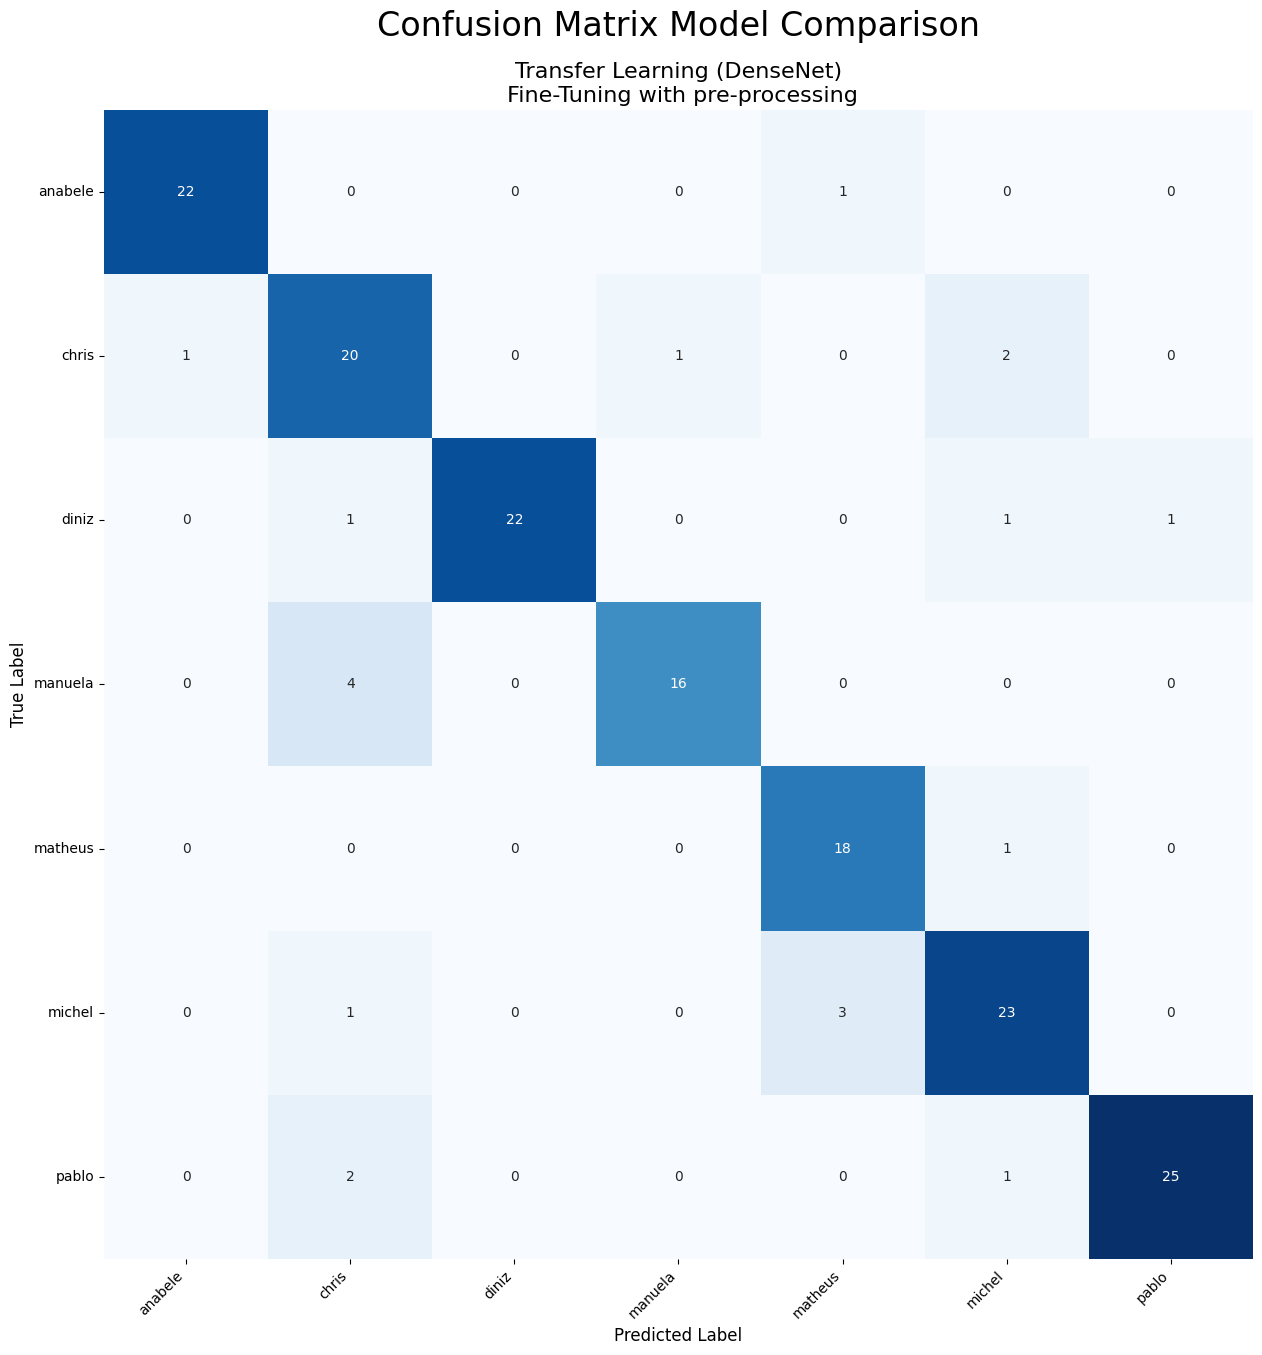

In [ ]:
class_names = testing.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true=y_true,
                          y_pred=y_pred,
                          )
    sns.heatmap(cm,
                annot=True,
                square=True,
                xticklabels=class_names,
                yticklabels=class_names,
                fmt='d',
                cmap=plt.cm.Blues,
                cbar=False,
                ax=ax
                )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(figsize=(20, 10))

#plot_heatmap(true_classes, scratch_pred_classes, class_names, ax1, title="Custom CNN")
#plot_heatmap(true_classes, dense_pred_classes, class_names, ax1, title="Transfer Learning (DenseNet)\n No Fine-Tuning")
plot_heatmap(true_classes, dense_pred_classes, class_names, ax, title="Transfer Learning (DenseNet)\n Fine-Tuning with pre-processing")
#plot_heatmap(true_classes, dense_pred_classes, class_names, ax3, title="Transfer Learning (DenseNet)\n No Fine-Tuning")
#plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax3, title="Transfer Learning (VGG16) with Fine-Tuning")

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24, y=1.35)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()